## Lista de datos necesarios

In [ ]:
# datos que necesitamos:
    # datos censales de redatam
# Preparar shapefile de radios censales
# Modelación hidrológica
# limite de cuencas
# Equipamientos
# Barrios ReNaBap o RPPVA


### ReNaBap

In [1]:
import geopandas as gpd
import pandas as pd
from io import BytesIO
from owslib.wfs import WebFeatureService

In [ ]:
def wfs_to_gdf(wfs_url: str, layer_name: str, srs: str = "EPSG:4326") -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.
    
    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.
    
    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf

In [7]:
# Ejemplo de uso:
renabap = wfs_to_gdf(
     wfs_url="https://geoserver.opisu.gba.gob.ar/geoserver/ows?service=wfs",
     layer_name="IDEOPISU:2327_estimaciones_rppvap_renabap_23_ide",
     srs="EPSG:4326"
)

In [8]:
la_plata = renabap[renabap["depto"] == "La Plata"]

<Axes: >

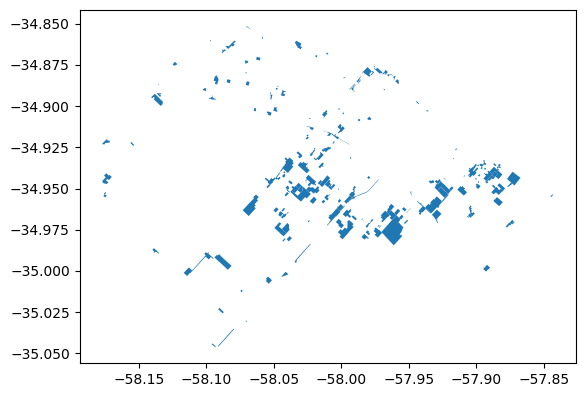

In [9]:
la_plata.plot()

### Equipamientos

### Límites de cuencas

In [10]:
# Ejemplo de uso:
cuencas = wfs_to_gdf(
     wfs_url="https://www.minfra.gba.gob.ar/sig_hidraulica/geoserver/dipsoh/wfs",
     layer_name="dipsoh:cuencas",
     srs="EPSG:900913"
)

<Axes: >

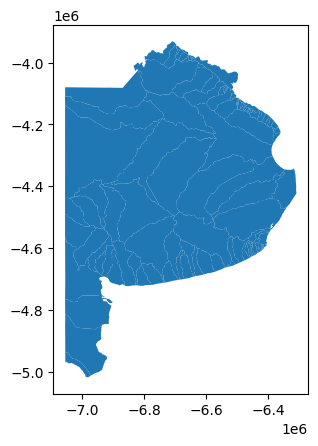

In [11]:
cuencas.plot()

### Radios censales

In [12]:
import requests
import zipfile
import io

# URL del archivo ZIP
url = "https://ri.conicet.gov.ar/bitstream/handle/11336/149711/RADIOS_2022_V2025-1.zip?sequence=2&isAllowed=y"

# Descargar el archivo ZIP
response = requests.get(url)
response.raise_for_status()  # Lanza un error si la descarga falla

# Extraer el ZIP en memoria
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("RADIOS_2022")  # Cambia el nombre de la carpeta si lo deseas

print("Descarga y extracción completadas.")

KeyboardInterrupt: 

### Modelación hidrológica

In [17]:
from google.cloud import storage
from google.oauth2 import service_account
from pathlib import Path
import os
from dotenv import load_dotenv
load_dotenv()

True

In [20]:
project_root = Path.cwd()
credentials_path = project_root / os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

# Initialize client with credentials and project from environment
credentials = service_account.Credentials.from_service_account_file(
    str(credentials_path)
)
client = storage.Client(
    credentials=credentials, project=os.getenv("GOOGLE_CLOUD_PROJECT")
)

# Get bucket name from environment
bucket_name = os.getenv("GOOGLE_CLOUD_BUCKET")
bucket = client.bucket(bucket_name)

In [25]:
# List all blobs in the 2023 directory
prefix = "2023/"
print(f"Searching for GIS files in {prefix}...")

# Get all blobs with the prefix
blobs = bucket.list_blobs(prefix=prefix)

# Filter for GIS files
gis_files = []
for blob in blobs:
    if blob.name.lower().endswith((".shp", ".geojson", ".json")):
        gis_files.append(blob.name)

# Print results
if gis_files:
    print("\nFound GIS files:")
    for file in gis_files:
        print(f"- {file}")
else:
    print("\nNo GIS files found in 2023 directory")

Searching for GIS files in 2023/...

Found GIS files:
- 2023/MAPAS/Vulnerabilidad-Exposicion-Riesgo_Noviembre 23/Shape/LP_Vulnerabilidad-Exposicion-Riesgo_23.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/RIESGO 2019/RIESGO_2019.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/RIESGO 2049/V_RURAL_2049.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/RIESGO 2049/V_URBANO_2049_f6.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/Sim_integrada.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/VULNERABILIDAD 2019/RURAL/Vu_rural_BAJA_lp.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/VULNERABILIDAD 2019/RURAL/Vu_rural_Berisso.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/VULNERABILIDAD 2019/RURAL/Vu_rural_Ensenada.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/VULNERABILIDAD 2019/RURAL/Vu_rural_MEDIA_lp.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/VULNERABILIDAD 2019/URBANA/VULNERABILIDAD_ByE.shp
- 2023/RRI-SHP/Antecedentes RRI 2019/SHAPES/VULNERABILIDAD 2019/URBANA/VULNERABILIDAD_lp.shp
-

In [28]:
import geopandas as gpd
from google.cloud import storage
from io import BytesIO
import os
import tempfile
import pandas as pd

prefix = "2023/RRI-SHP/Peligrosidad 2023-por Cuenca/"
bucket_name = os.getenv("GOOGLE_CLOUD_BUCKET")
client = storage.Client()
bucket = client.bucket(bucket_name)

print("Buscando archivos .shp en todas las subcarpetas...")
shp_blobs = [blob for blob in bucket.list_blobs(prefix=prefix) if blob.name.endswith(".shp")]
print(f"Se encontraron {len(shp_blobs)} archivos .shp.")

def read_shapefile_from_gcs_to_temp(blob_name):
    base = blob_name[:-4]
    extensions = [".shp", ".shx", ".dbf", ".prj"]  # .cpg es opcional
    with tempfile.TemporaryDirectory() as tmpdir:
        local_files = {}
        for ext in extensions:
            b = bucket.blob(base + ext)
            if not b.exists():
                print(f"  ⚠️  Falta el archivo {base + ext}, se omite {base}.shp")
                return None
            local_path = os.path.join(tmpdir, os.path.basename(base + ext))
            with open(local_path, "wb") as f:
                f.write(b.download_as_bytes())
            local_files[ext] = local_path
        try:
            gdf = gpd.read_file(local_files[".shp"])
            print(f"  ✅ {os.path.basename(blob_name)} cargado correctamente ({len(gdf)} registros).")
            return gdf
        except Exception as e:
            print(f"  ❌ Error leyendo {base}.shp: {e}")
            return None

gdfs = []
for i, blob in enumerate(shp_blobs):
    print(f"\nProcesando archivo {i+1}/{len(shp_blobs)}: {blob.name}")
    gdf = read_shapefile_from_gcs_to_temp(blob.name)
    if gdf is not None:
        gdfs.append(gdf)

if gdfs:
    crs = gdfs[0].crs
    gdfs = [gdf.to_crs(crs) for gdf in gdfs]
    peligrosidad_todas = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=crs)
    print(f"\n✅ Se unieron {len(gdfs)} shapefiles en un solo GeoDataFrame con {len(peligrosidad_todas)} registros.")
else:
    print("\n❌ No se pudo cargar ningún shapefile correctamente.")

Buscando archivos .shp en todas las subcarpetas...
Se encontraron 52 archivos .shp.

Procesando archivo 1/52: 2023/RRI-SHP/Peligrosidad 2023-por Cuenca/Cuenca Abascay/c-abascay23_peli_alta.shp
  ✅ c-abascay23_peli_alta.shp cargado correctamente (1 registros).

Procesando archivo 2/52: 2023/RRI-SHP/Peligrosidad 2023-por Cuenca/Cuenca Abascay/c-abascay23_peli_baja.shp
  ✅ c-abascay23_peli_baja.shp cargado correctamente (1 registros).

Procesando archivo 3/52: 2023/RRI-SHP/Peligrosidad 2023-por Cuenca/Cuenca Abascay/c-abascay23_peli_mbaja-nula.shp
  ✅ c-abascay23_peli_mbaja-nula.shp cargado correctamente (1 registros).

Procesando archivo 4/52: 2023/RRI-SHP/Peligrosidad 2023-por Cuenca/Cuenca Abascay/c-abascay23_peli_media.shp
  ✅ c-abascay23_peli_media.shp cargado correctamente (1 registros).

Procesando archivo 5/52: 2023/RRI-SHP/Peligrosidad 2023-por Cuenca/Cuenca Afluente_SB/c-Afluente-SB23_peli_alta.shp
  ✅ c-Afluente-SB23_peli_alta.shp cargado correctamente (1 registros).

Procesand

<Axes: >

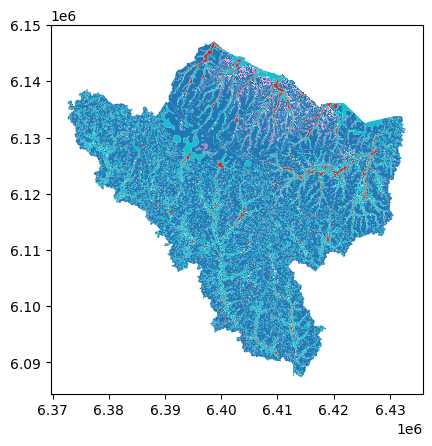

In [32]:
peligrosidad_todas.plot("PELIGROSID")

In [23]:
r100_peligrosidad_blob = bucket.blob(
    "2024/archivos en JSON/JSON_Anteriores/R100_peligrosidad.geojson"
)
r100_peligrosidad_content = r100_peligrosidad_blob.download_as_bytes()
r100_peligrosidad = gpd.read_file(BytesIO(r100_peligrosidad_content))

<Axes: >

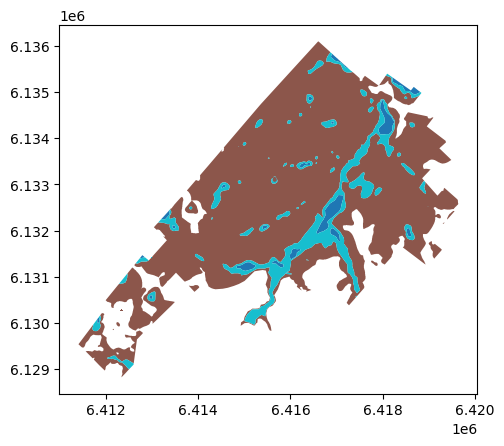

In [24]:
r100_peligrosidad.plot("Peligro")

## Pasos del procesamiento

In [ ]:
## Generar el proyecto en QGis
## Añadir la capa de radios y ajustar el sistema de proyeccion a POSGAR Faja 5
## Limpiar la tabla de atributos
## Generar el atributo "link"
## Utilizar "join" para pegar los datos censales a la capa de radios
## Clasificacion de niveles de las vulnerabilidades
## Cruce de vulnerabilidades para obtener la vulnerabilidad general
## procesamiento de superposición para obtener el riesgo a partir de la peligrosidad paraa obtener los niveles de riesgo
## Aplicar simbología de categorizacion para obtener el mapa de color
## Calcular areas por cuenca y por niveles de riesgo y vulnerabilidad
## Generar el diseño de implesión
## Exportar mapas en .pdf y .jpg en tamaño A3


## Lista de productos finales

In [ ]:
# Mapa de vulnerabilidad general
# Mapa de riesgo
# Mapa de vulnerabilidad fisica
# Mapa de vulnerabilidad ambiental
# Mapa de vulnerabilidad socioeconomica
# Mapa de exposicion
# cuantificacion de resultados